In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense,Flatten

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0,EfficientNetB4,Xception
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
import glob
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_excel("/content/drive/My Drive/input/augmented_intensity_raw_.xlsx")
test= pd.read_csv("/content/drive/My Drive/input/insat_3d_ds-Sheet.csv")

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = datagen.flow_from_dataframe(
    train,
    directory="/content/drive/My Drive/input/augmented_raw_",
    x_col="img_name",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='raw',
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    train,
    directory="/content/drive/My Drive/input/augmented_raw_",
    x_col="img_name",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='raw',
    subset="training"
)

Found 680 validated image filenames.
Found 680 validated image filenames.


# EfficientNet

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - loss: 1236.6686 - root_mean_squared_error: 34.6258
Epoch 1: val_root_mean_squared_error improved from inf to 25.10075, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_EfficientNetb7_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 1227.8804 - root_mean_squared_error: 34.5015 - val_loss: 630.0476 - val_root_mean_squared_error: 25.1007
Epoch 2/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 508.2541 - root_mean_squared_error: 22.5349
Epoch 2: val_root_mean_squared_error improved from 25.10075 to 21.99621, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_EfficientNetb7_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 365ms/step - loss: 509.4288 - root_mean_squared_error: 22.5611 - val_loss: 483.8332 - val_root_mean_squared_error: 21.9962
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 509.2042 - root_mean_squared_error: 22.5464
Epoch 3: val_root_mean_squa

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


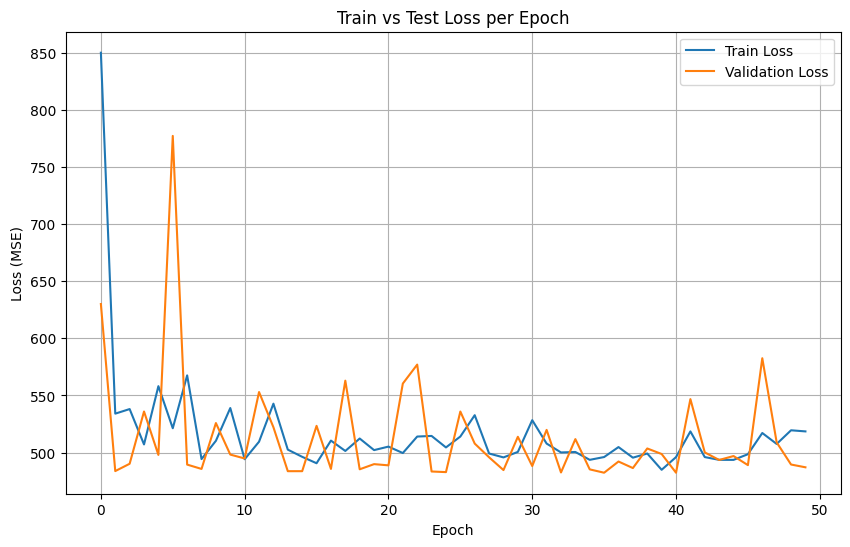

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


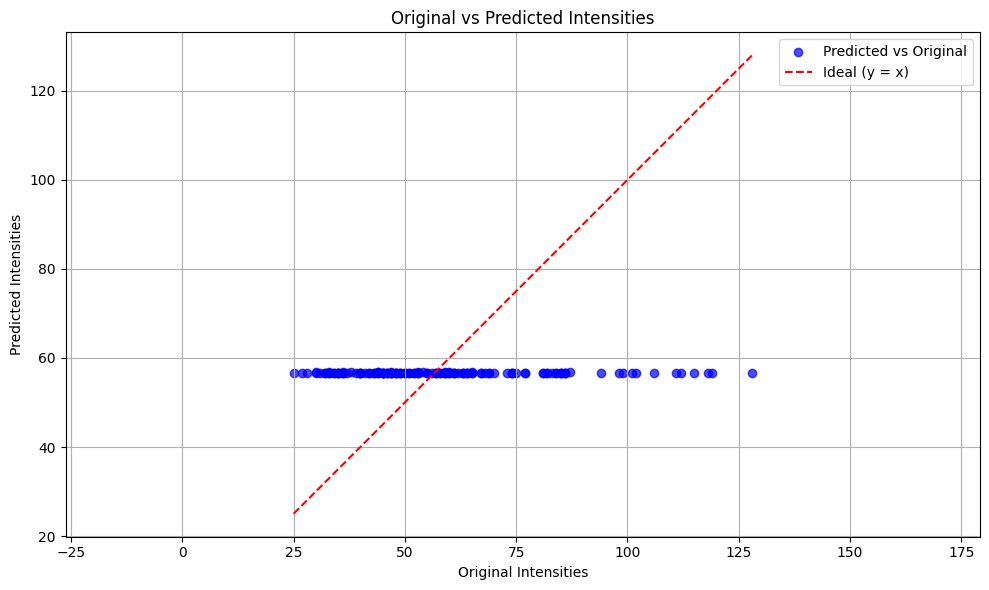

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def build_model():
    try:
        base = tf.keras.applications.EfficientNetB7(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
        base.trainable = False
        flatten = base.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(64, activation="relu")(flatten)
        bboxHead = Dense(32, activation="relu")(bboxHead)
        bboxHead = Dense(1, activation="linear")(bboxHead)
        model = Model(inputs=base.input, outputs=bboxHead)
        return model
    except Exception as e:
        print(f"Error in building model: {e}")
        return None

model = build_model()

if model is not None:
    save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_EfficientNetb7_weights.weights.h5",
                                                   monitor='val_root_mean_squared_error',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=50,
                        callbacks=[save_best])
    model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/EFFICIENTNETB7_model.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)

def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values
    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    images = np.array(images)
    predicted_intensities = model.predict(images)
    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)
    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })
    return results

original_intensities = val_labels.flatten()
predicted_intensities = predictions.flatten()
image_paths = val_data.filenames

plot_train_test_loss(history)

results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)

results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/EFFICIENTNETB7_prediction.csv", index=False)


# EfficientNetB3

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def build_model():
    try:
        base = tf.keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
        base.trainable = False
        flatten = base.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(64, activation="relu")(flatten)
        bboxHead = Dense(32, activation="relu")(bboxHead)
        bboxHead = Dense(1, activation="linear")(bboxHead)
        model = Model(inputs=base.input, outputs=bboxHead)
        return model
    except Exception as e:
        print(f"Error in building model: {e}")
        return None

model = build_model()

if model is not None:
    save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_EfficientNetb7_weights.weights.h5",
                                                   monitor='val_root_mean_squared_error',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=50,
                        callbacks=[save_best])
    model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/EFFICIENTNETB7_model.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)

def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values
    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    images = np.array(images)
    predicted_intensities = model.predict(images)
    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)
    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })
    return results

original_intensities = val_labels.flatten()
predicted_intensities = predictions.flatten()
image_paths = val_data.filenames

plot_train_test_loss(history)

results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)

results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/EFFICIENTNETB7_prediction.csv", index=False)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/50
24/43 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1398.0245 - root_mean_squared_error: 36.4156

# Using Exception

Epoch 1/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1372.9167 - root_mean_squared_error: 35.4615
Epoch 1: val_root_mean_squared_error improved from inf to 17.85963, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_Xception_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 1341.9916 - root_mean_squared_error: 35.0458 - val_loss: 318.9663 - val_root_mean_squared_error: 17.8596
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 303.7796 - root_mean_squared_error: 17.4199
Epoch 2: val_root_mean_squared_error improved from 17.85963 to 14.44391, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_Xception_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 303.6514 - root_mean_squared_error: 17.4164 - val_loss: 208.6264 - val_root_mean_squared_error: 14.4439
Epoch 3/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 206.3314 - root_mean_squared_error: 14.3345
Epoch 3: val_root_mean_squared_error impr

1/1 ━━━━━━━━━━━━━━━━━━━━ 173s 173s/step


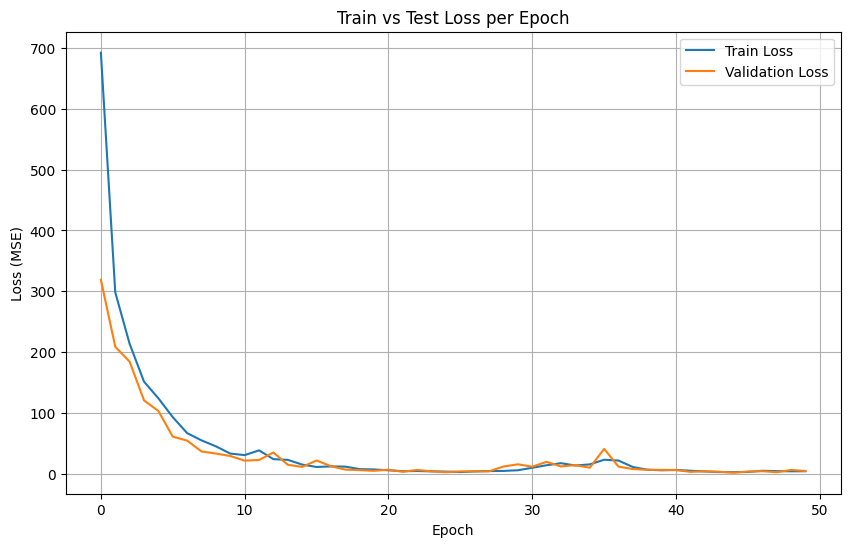

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step


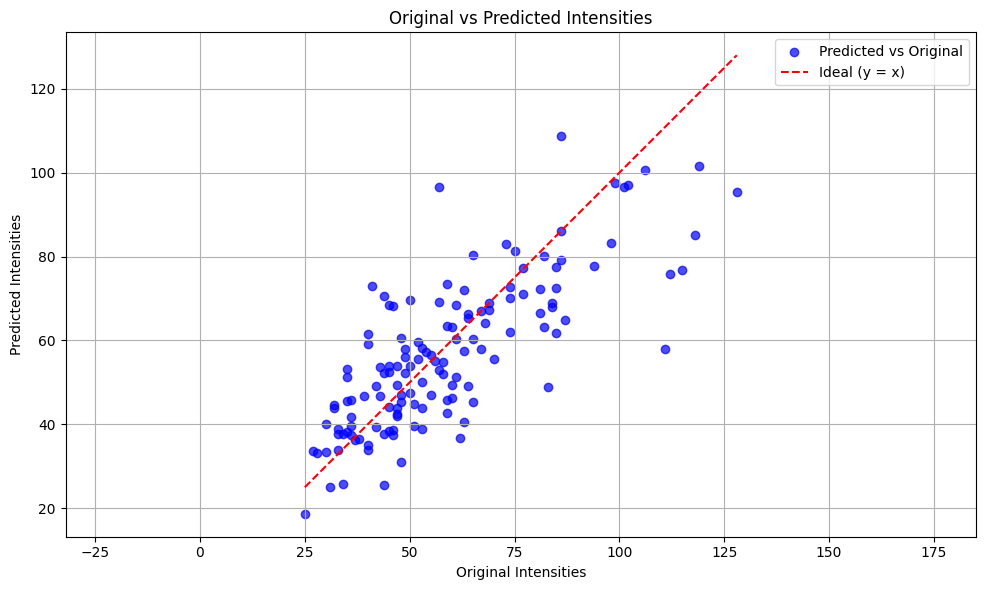

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def build_model():
    try:
        base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
        base.trainable = False
        flatten = base.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(64, activation="relu")(flatten)
        bboxHead = Dense(32, activation="relu")(bboxHead)
        bboxHead = Dense(1, activation="linear")(bboxHead)
        model = Model(inputs=base.input, outputs=bboxHead)
        return model
    except Exception as e:
        print(f"Error in building model: {e}")
        return None

model = build_model()

if model is not None:
    save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_Xception_weights.weights.h5",
                                                   monitor='val_root_mean_squared_error',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=50,
                        callbacks=[save_best])
    model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/XCEPTION_model.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)

def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values
    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    images = np.array(images)
    predicted_intensities = model.predict(images)
    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)
    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([25,128], [25,128], color='red', linestyle='--', label='Ideal (y = x)')
    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })
    return results

original_intensities = val_labels.flatten()
predicted_intensities = predictions.flatten()
image_paths = val_data.filenames

plot_train_test_loss(history)

results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)

results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/XCEPTION_prediction.csv", index=False)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


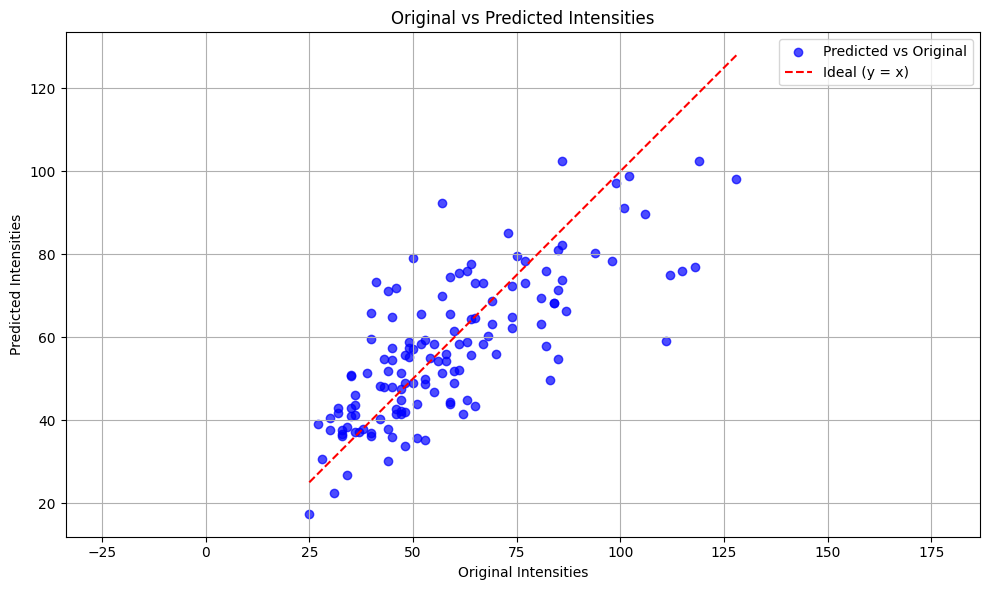

In [ ]:
def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values
    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    images = np.array(images)
    predicted_intensities = model.predict(images)
    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)
    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([25,128], [25,128], color='red', linestyle='--', label='Ideal (y = x)')
    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })
    return results

# Call the function
results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)


#RESNET

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 2755.0569 - root_mean_squared_error: 51.6380
Epoch 1: val_root_mean_squared_error improved from inf to 39.02835, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_ResNet50_weights.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 2721.4529 - root_mean_squared_error: 51.2979 - val_loss: 1523.2126 - val_root_mean_squared_error: 39.0284
Epoch 2/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 458.3828 - root_mean_squared_error: 21.3723 
Epoch 2: val_root_mean_squared_error improved from 39.02835 to 31.23563, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_ResNet50_weights.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 456.0523 - root_mean_squared_error: 21.3187 - val_loss: 975.6644 - val_root_mean_squared_error: 31.2356
Epoch 3/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 441.4443 - root_mean_squared_

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


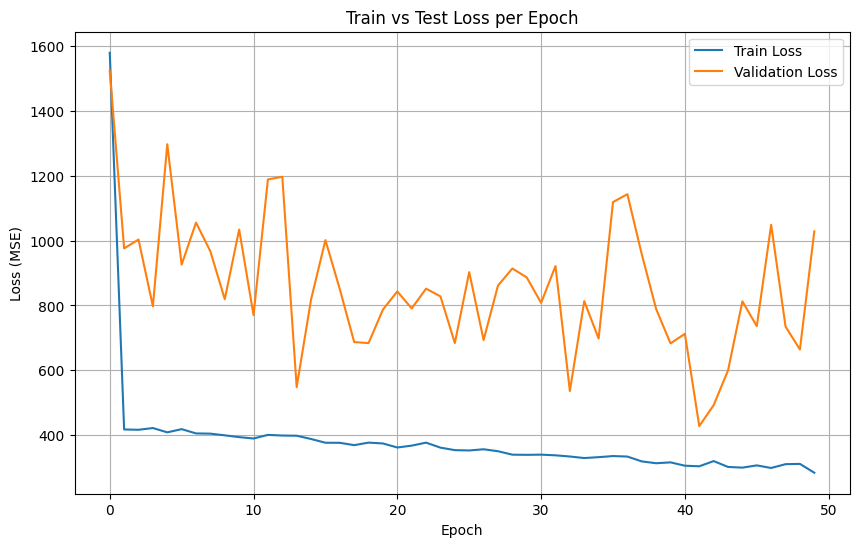

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step


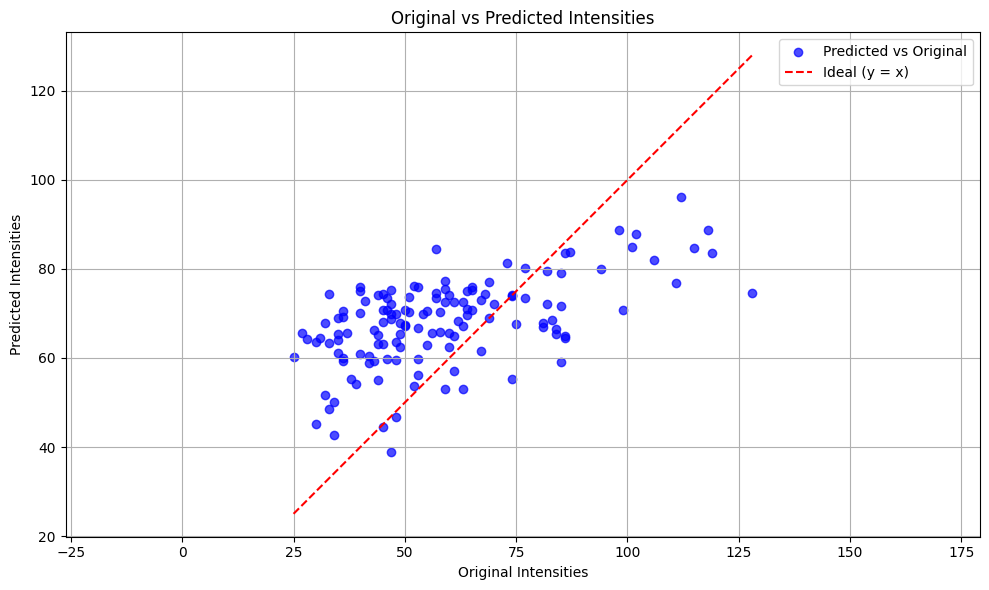

In [ ]:
def build_model():
    base = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    return model

model = build_model()

save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_ResNet50_weights.weights.h5",
                                               monitor='val_root_mean_squared_error',
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=50,
                    callbacks=[save_best])

model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/RES_NET.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)


def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values

    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

    images = np.array(images)

    predicted_intensities = model.predict(images)

    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)

    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')

    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })

    return results

original_intensities = val_labels.flatten()
predicted_intensities = predictions.flatten()

image_paths = val_data.filenames

plot_train_test_loss(history)

results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)

results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/RES_NET_prediction.csv", index=False)


# Inception ResNet

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 1374.2469 - root_mean_squared_error: 36.1396
Epoch 1: val_root_mean_squared_error improved from inf to 20.96474, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_RegNet_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 1362.5690 - root_mean_squared_error: 35.9849 - val_loss: 439.5203 - val_root_mean_squared_error: 20.9647
Epoch 2/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 411.8856 - root_mean_squared_error: 20.2887
Epoch 2: val_root_mean_squared_error improved from 20.96474 to 17.88964, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_RegNet_weights.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 411.1399 - root_mean_squared_error: 20.2704 - val_loss: 320.0393 - val_root_mean_squared_error: 17.8896
Epoch 3/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 319.8495 - root_mean_squared_error: 17.8456
Epoch 3: val_root_mean_squared_error improved f

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 993ms/step


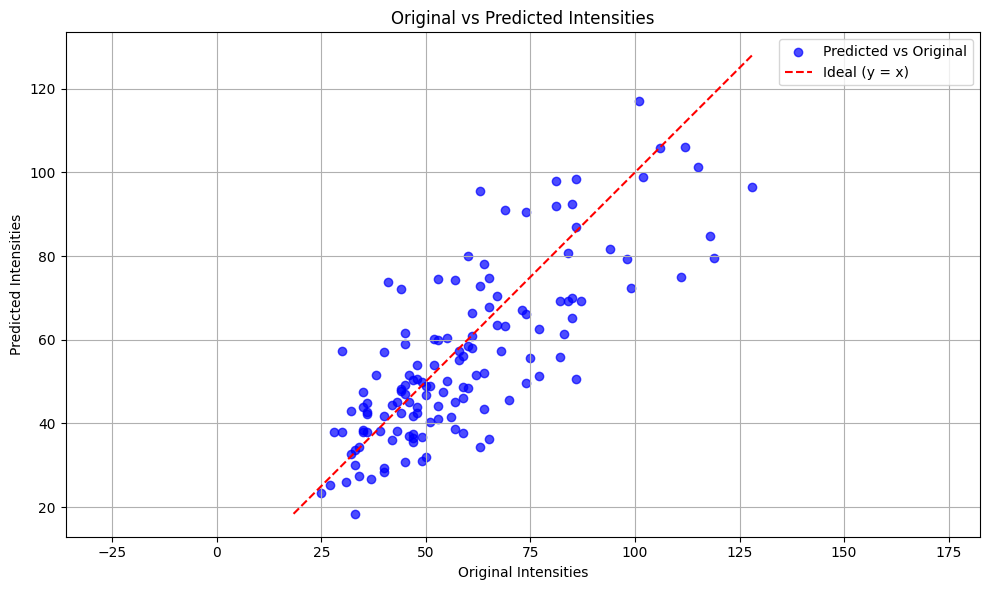

In [ ]:
def build_model():
    base = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
    base.trainable = False
    flatten = base.output
    flatten = Flatten()(flatten)
    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)
    model = Model(inputs=base.input, outputs=bboxHead)
    return model

model = build_model()

save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_InceptionResNetV2_weights.weights.h5",
                                               monitor='val_root_mean_squared_error',
                                               save_best_only=True,
                                               save_weights_only=True,
                                               verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=50,
                    callbacks=[save_best])
model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/InceptionResNetV2_model.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)

def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values

    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

    images = np.array(images)

    predicted_intensities = model.predict(images)

    # Ensure predicted_intensities is a flat array
    predicted_intensities = predicted_intensities.flatten()

    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)

    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')

    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities
    })

    return results
results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)
results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/InceptionResNetV2_prediction.csv", index=False)


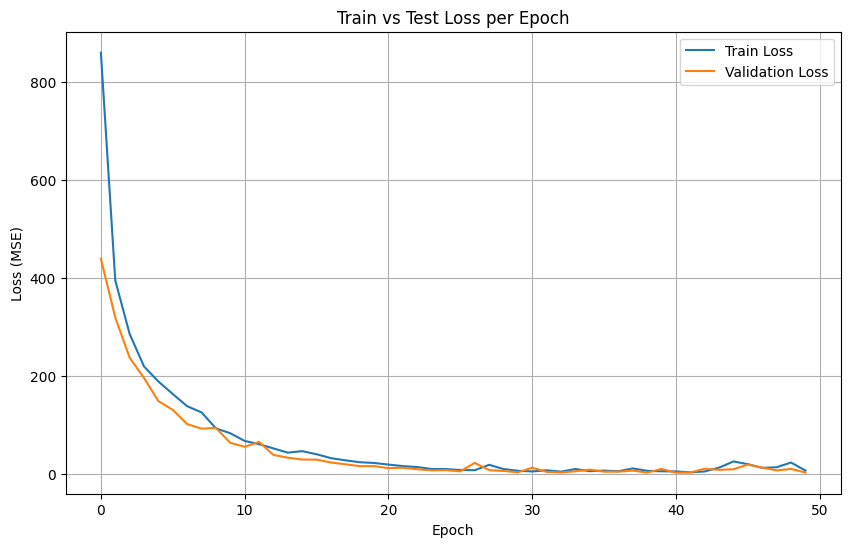

In [ ]:
plot_train_test_loss(history)

# MobileNetV3

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2526.4326 - root_mean_squared_error: 49.3862
Epoch 1: val_root_mean_squared_error improved from inf to 39.34174, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_MobileNetV3weights.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - loss: 2460.8398 - root_mean_squared_error: 48.6857 - val_loss: 1547.7729 - val_root_mean_squared_error: 39.3417
Epoch 2/50
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 452.7146 - root_mean_squared_error: 21.2395
Epoch 2: val_root_mean_squared_error improved from 39.34174 to 31.84338, saving model to /content/drive/MyDrive/Cyclone_Intensity_Estimation/best_MobileNetV3weights.weights.h5
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 448.4980 - root_mean_squared_error: 21.1426 - val_loss: 1014.0007 - val_root_mean_squared_error: 31.8434
Epoch 3/50
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 415.9722 - root_mean_squar

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 540ms/step


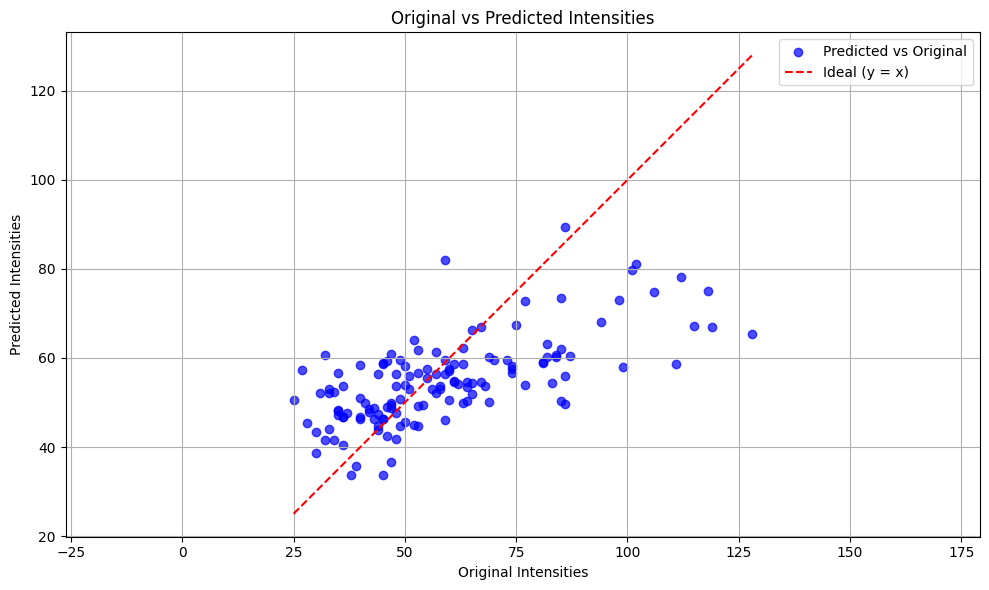

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def build_model():
    try:
        base = tf.keras.applications.MobileNetV3Large(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
        base.trainable = False
        flatten = base.output
        flatten = Flatten()(flatten)
        bboxHead = Dense(64, activation="relu")(flatten)
        bboxHead = Dense(32, activation="relu")(bboxHead)
        bboxHead = Dense(1, activation="linear")(bboxHead)
        model = Model(inputs=base.input, outputs=bboxHead)
        return model
    except Exception as e:
        print(f"Error in building model: {e}")
        return None

model = build_model()

if model is not None:
    save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Cyclone_Intensity_Estimation/best_MobileNetV3weights.weights.h5",
                                                   monitor='val_root_mean_squared_error',
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=50,
                        callbacks=[save_best])
    model.save('/content/drive/MyDrive/Cyclone_Intensity_Estimation/MOBILENETV3_model.h5')

def plot_train_test_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train vs Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

val_images, val_labels = next(val_data)
predictions = model.predict(val_images)

def plot_original_vs_predicted(data, image_dir, model):
    image_paths = data['img_name'].tolist()
    original_intensities = data['label'].values
    images = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    images = np.array(images)
    predicted_intensities = model.predict(images)
    plt.figure(figsize=(10, 6))
    plt.scatter(original_intensities, predicted_intensities, color='blue', label='Predicted vs Original', alpha=0.7)
    min_val = min(min(original_intensities), min(predicted_intensities))
    max_val = max(max(original_intensities), max(predicted_intensities))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
    plt.title("Original vs Predicted Intensities")
    plt.xlabel("Original Intensities")
    plt.ylabel("Predicted Intensities")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    results = pd.DataFrame({
        'Image Path': image_paths,
        'Original Intensity': original_intensities,
        'Predicted Intensity': predicted_intensities.flatten()
    })
    return results

results_df = plot_original_vs_predicted(test, '/content/drive/MyDrive/input/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL', model)
results_df.to_csv("/content/drive/MyDrive/Cyclone_Intensity_Estimation/MOBILENETV3_prediction.csv", index=False)
